# Convolutional Neural Network vs. Vision Transformer for Image Classification

## Setup

### Imports and Models

In [1]:
import numpy as np
import PIL
import torch
import os
import pandas as pd
from transformers import ViTImageProcessor, ViTForImageClassification, BitImageProcessor, BitForImageClassification

# Both ViT and BiT models classify images into one of 1000 classes from ImageNet
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224')
feature_extractor = BitImageProcessor.from_pretrained("google/bit-50")
bit_model = BitForImageClassification.from_pretrained("google/bit-50")

c:\Users\nikob\Documents\OTU_Schoolwork\Machine_Learning_Theory_and_Applications\final_project\virtualenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [28]:
# Returns the class index of the predicted class
def classify(model, processor, image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx

def load_data(directory=os.path.join('tiny_imagenet', 'val')):
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.JPEG'):
                img = PIL.Image.open(os.path.join(root, file))
                data.append((img, ))
    return data

def load_annotations(directory=os.path.join('tiny_imagenet')):
    filepath = os.path.join(directory, 'val', 'val_annotations.txt')
    annotations = pd.read_csv(filepath, sep='\t', header=None) 
    annotations = annotations.loc[:, [0, 1]].rename(
        columns={0: 'filename', 1: 'wnid'})
    classes = pd.read_csv(os.path.join(directory, 'words.txt'), sep='\t', header=None).rename(columns={0: 'wnid', 1: 'class'})
    annotations['class'] = annotations['wnid'].map(classes.set_index('wnid')['class'])
    annotations.drop(columns=['wnid'], inplace=True)
    return annotations

## Demo

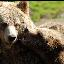

In [29]:
img_name = 'val_89.JPEG'
img = PIL.Image.open(os.path.normpath(f'tiny_imagenet/val/images/{img_name}'))
display(img)

In [30]:
annotations = load_annotations()

vit_pred_idx = classify(vit_model, processor, img)
print("ViT prediction:", vit_model.config.id2label[vit_pred_idx])
bit_pred_idx = classify(bit_model, feature_extractor, img)
print("BiT prediction:", bit_model.config.id2label[bit_pred_idx])
ground_truth = annotations.loc[annotations['filename'] == img_name, 'class'].values[0]
print("Ground truth:", ground_truth)

ViT prediction: brown bear, bruin, Ursus arctos
BiT prediction: sloth bear, Melursus ursinus, Ursus ursinus
Ground truth: brown bear, bruin, Ursus arctos
